# Preliminary operations

We import libraries and datasets.

In [ ]:
# Utility
from google.colab import drive
from shutil import copyfile
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# Image processing
import cv2
from PIL import Image

# KDTree
from sklearn.neighbors import KDTree
import joblib

# Keras
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2, resnet

In [ ]:
drive.mount('/content/gdrive')

We import the images of the actors from RAVDESS dataset.

In [ ]:
%cp -av '/content/gdrive/MyDrive/Digital Signal/Dataset/Actor_faces/' '/content/'

Now let's import the other dataset: CelebA, containing thousands of facial images of celebrities.

In [ ]:
!mkdir '/content/celeb'

In [ ]:
copyfile('/content/gdrive/MyDrive/Digital Signal/Dataset/Celeb_faces.zip', 'dataset.zip')

In [ ]:
!unzip 'dataset.zip' -d '/content/celeb'

# Data processing

We took a facial image for each actor with a neutral expression. Let's display an image.

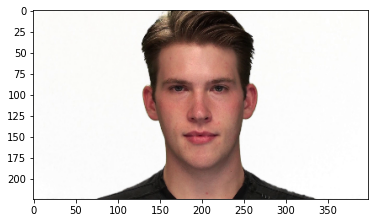

In [ ]:
im = cv2.imread('/content/Actor_faces/Actor_07.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
print(im.shape[:2])

(224, 398)


Let's explore some features of the celeb dataset.

In [ ]:
dir_list = os.listdir('/content/celeb/img_align_celeba/img_align_celeba/')
print(len(dir_list))

202599


We have 202599 celebrity images.

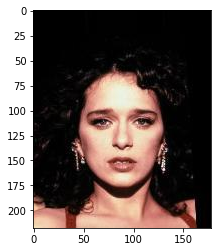

In [ ]:
im = cv2.imread('/content/celeb/img_align_celeba/img_align_celeba/100000.jpg')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
print(im.shape[:2])

(218, 178)


We check if height and width are the same for each image.

In [ ]:
for i in dir_list:
  im  = cv2.imread('/content/celeb/img_align_celeba/img_align_celeba/' + i)
  height, width = im.shape[:2]
  if (height != 218 or width != 178):
    print(height, width)
print('Same dimensions')

Same dimensions


The dimensions are standard: 218x178. 

In order to crop the background as much as possible, we use a Haar cascade classifier to detect and crop faces in both datasets.

In [ ]:
# Load the cascade classifier
face_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/Digital Signal/Dataset/haarcascade_frontalface_default.xml')

def crop_face(path, scaleFactor, minNeighbors):
  # Read the input image
  im = cv2.imread(path)
  # Convert the image to grayscale
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  # Detect faces in the image
  faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighbors)
  if len(faces) == 0:
    # We may try to decrease the scaleFactor parameter
    faces = face_cascade.detectMultiScale(gray, scaleFactor - 0.1, minNeighbors)
    if len(faces) == 0:
      return (0, 0)
    elif len(faces) > 1:
      return (1, 0)
    else:
      # Draw rectangles around the faces
      for (x, y, w, h) in faces:
        a, b, c = 0, 0, 0
        # Crop the face
        if(y-30 >= 0):
          a = 30
        if(y+h+10 < 218):
          b = 10
        if(x-5 >= 0 and x+w+5 < 178):
          c = 5
        face = im[y-a:y+h+b, x-c:x+w+c]
        return (2, face)
  elif len(faces) > 1:
    # We may try to increase the scaleFactor parameter
    faces = face_cascade.detectMultiScale(gray, scaleFactor + 0.1, minNeighbors)
    if len(faces) == 0:
      return (0, 0)
    elif len(faces) > 1:
      return (1, 0)
    else:
      # Draw rectangles around the faces
      for (x, y, w, h) in faces:
        a, b, c = 0, 0, 0
        # Crop the face
        if(y-30 >= 0):
          a = 30
        if(y+h+10 < 218):
          b = 10
        if(x-5 >= 0 and x+w+5 < 178):
          c = 5
        face = im[y-a:y+h+b, x-c:x+w+c]
        return (2, face)
  else:
  # Draw rectangles around the faces
    for (x, y, w, h) in faces:
      a, b, c = 0, 0, 0
      # Crop the face
      if(y-30 >= 0):
        a = 30
      if(y+h+10 < 218):
        b = 10
      if(x-5 >= 0 and x+w+5 < 178):
        c = 5
      face = im[y-a:y+h+b, x-c:x+w+c]
      return (2, face)

We crop (by means of the function crop_face) the actor faces and save them.

In [ ]:
dir_list = os.listdir('/content/Actor_faces/')
dir_list.sort()

for el in dir_list:
  res = crop_face('/content/Actor_faces/' + el, 1.12, 9)
  if res[0] == 2:
    cv2.imwrite('/content/Actor_faces/' + el, res[1])
  else:
    print('Didn\'t found a unique face for ' + el)

Let's see an example.

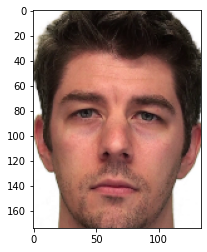

In [ ]:
im = cv2.imread('/content/Actor_faces/Actor_09.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

We crop (by means of the function crop_face) the celebrity faces and save them.

In [ ]:
dir_list = os.listdir('/content/celeb/img_align_celeba/img_align_celeba/')
dir_list.sort()

to_remove = []
for el in dir_list:
  res = crop_face('/content/celeb/img_align_celeba/img_align_celeba/' + el, 1.12, 5)
  if res[0] == 2:
    cv2.imwrite('/content/celeb/img_align_celeba/img_align_celeba/' + el, res[1])
  else:
    # If we don't find a unique face, we save the index to delete it in the next cell
    to_remove.append(el)

print('Images to delete: '+ str(len(to_remove)) + '/202599.')

Images to delete: 5210/202599.


In [ ]:
for el in to_remove:
  os.remove('/content/celeb/img_align_celeba/img_align_celeba/' + el)

We remove the celebrities even from the dataframe that we'll use later to estimate the accuracy.

In [ ]:
df_celeba = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_celeba.csv')

In [ ]:
for el in to_remove:
  df_celeba = df_celeba[df_celeba['image_id'] != el]

print(len(df_celeba))
df_celeba.reset_index(inplace = True, drop = True)
df_celeba.to_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_celeba.csv', index = False)

197389


We rename the paths for both actors and celebrities for a better comprehension and because we removed some images from celebrities, so at present we cannot iterate the folder sequentially.

In [ ]:
dir_list = os.listdir('/content/Actor_faces/')
dir_list.sort()

name = 0
for i in dir_list:
  os.rename('/content/Actor_faces/' + i, '/content/Actor_faces/' + str(name).zfill(2) + '.png')
  name+=1

In [ ]:
dir_list = os.listdir('/content/celeb/img_align_celeba/img_align_celeba/')
dir_list.sort()

name = 0
for i in dir_list:
  os.rename('/content/celeb/img_align_celeba/img_align_celeba/' + i, '/content/celeb/img_align_celeba/img_align_celeba/' + str(name).zfill(6) + '.jpg')
  name+=1

In [ ]:
!mkdir '/content/gdrive/MyDrive/Digital Signal/Dataset/celeba'

In [ ]:
%cp -av '/content/celeb/img_align_celeba/img_align_celeba/' '/content/gdrive/MyDrive/Digital Signal/Dataset/celeba/'

Let's display an example.

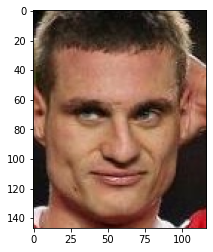

In [ ]:
im = cv2.imread('/content/celeb/img_align_celeba/img_align_celeba/120000.jpg')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

Now, we can add a custom background to our query images (i.e. the actors), in order to make them more realistic and less biased.

In [ ]:
dir_list = os.listdir('/content/Actor_faces/')
dir_list.sort()

for el in dir_list:
  # First of all we make the background transparent
  im = Image.open('/content/Actor_faces/' + el)
  im = im.convert("RGBA")
  data = im.getdata()
  newData = []
  # Set alpha = 0 if the pixel is white (or almost white)
  for item in data:
    if item[0] >= 240 and item[1] >= 240 and item[2] >= 240:
      newData.append((255, 255, 255, 0))
    else:
      newData.append(item)
  im.putdata(newData)
  # Now we paste the actor into the background
  bg = Image.open('/content/gdrive/MyDrive/Digital Signal/Dataset/Backgrounds/' + el) 
  # Resize the background image according to the same actor image dimension
  bg = bg.resize(im.size)
  bg.paste(im, (0, 0), im)
  # Save the final image
  bg.save('/content/Actor_faces/' + el)

The images must fit with the input of the neural networks, so we will resize the images to 224x224. Then, we will preprocess them according to the network used (both ResNet and MobileNetV2 need images with values between 0 and 255).

Let's see two example of resizing.

(0.0, 250.0)
(224, 224, 3)


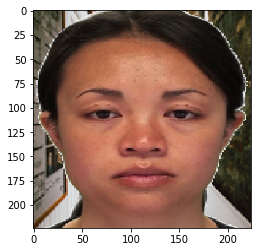

In [ ]:
im = kimage.load_img('/content/Actor_faces/17.png', target_size = (224,224))
plt.imshow(im)
x = kimage.img_to_array(im)
print((x.min(), x.max()))
print(x.shape)

(0.0, 255.0)
(224, 224, 3)


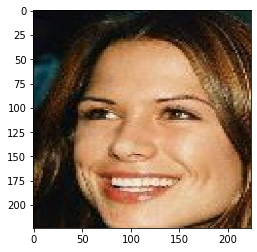

In [ ]:
im = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/100000.jpg', target_size = (224,224))
plt.imshow(im)
x = kimage.img_to_array(im)
print((x.min(), x.max()))
print(x.shape)

# MobileNetV2

As a first approach, we use a MobileNetV2 as feature extractor. This is a light network and each image will be converted into a vector composed by 1280 features.

In [ ]:
mobilenet = keras.applications.MobileNetV2(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False, pooling = 'max')

## Feature extraction

In order to optimize operations, we use list comprehension and a function to create the features. This saves us computation time by avoiding the append method.

For each image:
1.   Read image through Keras.
2.   Convert into numpy array.
3.   Apply preprocessing function.
4.   Return features.

The fill parameter is used in order to pad the index with the related name of the path (i.e. for celebrities index 91 becomes the path relative to 000091.jpg, for actors index 8 becomes the path relative to 08.png).

The path parameter is used in order to distinguish between query images and celeb images.

In [ ]:
def features_func(i, fill, path):
  # Load image
  im = kimage.load_img(path[:-4] + str(i).zfill(fill) + path[-4:], target_size = (224, 224))
  # Convert into numpy array
  x = kimage.img_to_array(im)
  # Preprocessing according to MobileNetV2
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  # Expand dimensions
  x = np.expand_dims(x, axis = 0)
  # Extract features
  feat = mobilenet.predict(x, verbose = False)
  # Return features
  return feat.flatten()

We create a list for celebrities, where each value represents the feature vector for the related image.

In [ ]:
dir_list = os.listdir('/content/gdrive/MyDrive/Digital Signal/Dataset/celeb')
dir_list.sort()

features_celeb = [features_func(i, 6, path = '/content/celeb/img_align_celeba/img_align_celeba/.jpg') for i in range(len(dir_list))]

In [ ]:
features_celeb = np.array(features_celeb)
features_celeb.shape

## KDTree

Building the search tree by means of KDTree from scikit-learn. 

In [ ]:
tree = KDTree(features_celeb)

Let's save the tree.

In [ ]:
joblib.dump(tree, '/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/mob_tree.joblib')

At this point, we could restart the runtime in order to avoid RAM issues due to the features and the tree previously computed.

## Query

We query the tree that we previously saved. Specifically, we take the first 2 nearest-neighbors for each actor.

In [ ]:
tree = joblib.load('/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/mob_tree.joblib')

In [ ]:
dir_list = os.listdir('/content/Actor_faces/')
dir_list.sort()

features_actors = [features_func(i, 2, path = '/content/Actor_faces/.png') for i in range(len(dir_list))]

In [ ]:
features_actors = np.array(features_actors)
features_actors.shape

(24, 1280)

In [ ]:
dist, ind = tree.query(features_actors, k = 2)

## Evaluation

In order to evaluate our results in a quantitative way, we compare some features from actors and celebrities, which have been stored separately in a csv. These features are in a binary format (e.g. Male = 1 or -1, Brown_Hair = 1 or -1). If we take, as accuracy measure, the ratio between the common features and the toal number of features, we may provide an empirical (but quantitative) way to measure the quality of retrieval.

In [ ]:
df_actors = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_actors.csv')
df_celeba = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_celeba.csv')

In [ ]:
print('List of binary features:\n')
# We don't consider the first column because is the id of the image
print(list(df_actors.columns[1:]))

List of binary features:

['Arched_Eyebrows', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


Now we create, for both the images retrieved by KDTree as a match for each query, a list containing the values for accuracy and distance for each actor. Finally, we provide the final "accuracy score" by averaging the single accuracies on the actors.

In [ ]:
# Initializing lists
acc_list_1 = []
acc_list_2 = []
best_acc_list = []
dist_list_1 = []
dist_list_2 = []

# We don't consider the first column because is the id of the image
cols = df_actors.columns[1:]

# Compute accuracy and distance for each actor
for i in range(0, len(df_actors)):
  print('Actor ' + str(i + 1) + ':')
  count_1 = 0
  count_2 = 0
  # Save distances between actor and celebrity for both images
  dist_1 = round(dist[i][0], 2)
  dist_2 = round(dist[i][1], 2)
  dist_list_1.append(dist_1)
  dist_list_2.append(dist_2)
  # Save indices related to the actor for both images
  ind_1 = ind[i][0]
  ind_2 = ind[i][1]
  # Now we compute the matches between the binary atributes
  for j in cols:
    # Compute matches for the first image
    if(df_actors[j][i] == df_celeba[j][ind_1]):
      count_1+=1
    # Compute matches for the second image
    if(df_actors[j][i] == df_celeba[j][ind_2]):
      count_2+=1
  
  # Compute accuracy for the first image
  acc_1 = round((count_1/len(cols))*100, 2)
  acc_list_1.append(acc_1)
  print('Accuracy for first image: ' + str(acc_1) + '%')
  print('Distance for first image: ' + str(dist_1))

  # Compute accuracy for the second image
  acc_2 = round((count_2/len(cols))*100, 2)
  acc_list_2.append(acc_2)
  print('Accuracy for second image: ' + str(acc_2) + '%')
  print('Distance for second image: ' + str(dist_2) + '\n')

  # Saving best result
  best_acc_list.append(max(acc_1, acc_2))

print('Mean accuracy for first image: ' + str(round(np.mean(acc_list_1), 2)))
print('Mean accuracy for second image: ' + str(round(np.mean(acc_list_2), 2)))
print('Mean accuracy for top-2 images: ' + str(round(np.mean(best_acc_list), 2)))
print('Mean distance for first image: ' + str(round(np.mean(dist_list_1), 2)))
print('Mean distance for second image: ' + str(round(np.mean(dist_list_2), 2)))

Actor 1:
Accuracy for first image: 70.27%
Distance for first image: 64.54
Accuracy for second image: 81.08%
Distance for second image: 66.66

Actor 2:
Accuracy for first image: 67.57%
Distance for first image: 57.99
Accuracy for second image: 62.16%
Distance for second image: 58.5

Actor 3:
Accuracy for first image: 81.08%
Distance for first image: 65.63
Accuracy for second image: 81.08%
Distance for second image: 66.53

Actor 4:
Accuracy for first image: 78.38%
Distance for first image: 69.78
Accuracy for second image: 81.08%
Distance for second image: 70.17

Actor 5:
Accuracy for first image: 70.27%
Distance for first image: 63.88
Accuracy for second image: 83.78%
Distance for second image: 65.53

Actor 6:
Accuracy for first image: 86.49%
Distance for first image: 69.69
Accuracy for second image: 78.38%
Distance for second image: 69.93

Actor 7:
Accuracy for first image: 75.68%
Distance for first image: 76.48
Accuracy for second image: 78.38%
Distance for second image: 77.12

Actor 8

* The total "empirical accuracy" for the first image is equal to 77.59%.
* The total "empirical accuracy" for the top-2 images is equal to 81.08%.

We may display the top results in terms of accuracy from Actor6 (86.49%), Actor15 (86.49%) and Actor21 (86.49%).

Text(0.5, 1.0, 'Acc: 86.49%')

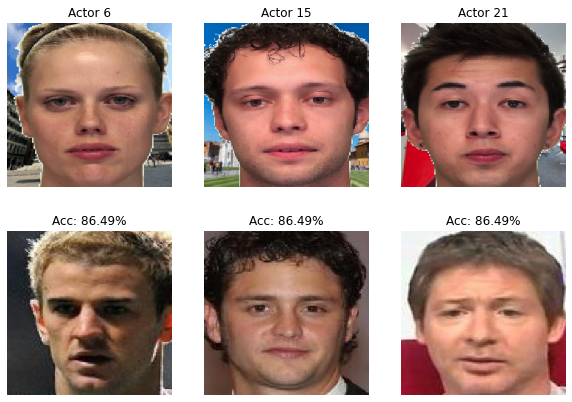

In [ ]:
im6 = kimage.load_img('/content/Actor_faces/05.png', target_size = (224, 224))
im15 = kimage.load_img('/content/Actor_faces/14.png', target_size = (224, 224))
im21 = kimage.load_img('/content/Actor_faces/20.png', target_size = (224, 224))

im6_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[5][0]).zfill(6) + '.jpg', target_size = (224, 224))
im15_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[14][0]).zfill(6) + '.jpg', target_size = (224, 224))
im21_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[20][0]).zfill(6) + '.jpg', target_size = (224, 224))

fig = plt.figure(figsize = (10, 7))

fig.add_subplot(2, 3, 1)
plt.imshow(im6)
plt.axis('off')
plt.title("Actor 6")
fig.add_subplot(2, 3, 2)
plt.imshow(im15)
plt.axis('off')
plt.title("Actor 15")
fig.add_subplot(2, 3, 3)
plt.imshow(im21)
plt.axis('off')
plt.title("Actor 21")

fig.add_subplot(2, 3, 4)
plt.imshow(im6_celeb)
plt.axis('off')
plt.title("Acc: 86.49%")
fig.add_subplot(2, 3, 5)
plt.imshow(im15_celeb)
plt.axis('off')
plt.title("Acc: 86.49%")
fig.add_subplot(2, 3, 6)
plt.imshow(im21_celeb)
plt.axis('off')
plt.title("Acc: 86.49%")

We may display the top-3 results in terms distance from Actor2 (57.99), Actor5 (63.88) and Actor11 (63.51).

Text(0.5, 1.0, 'Dist: 63.51')

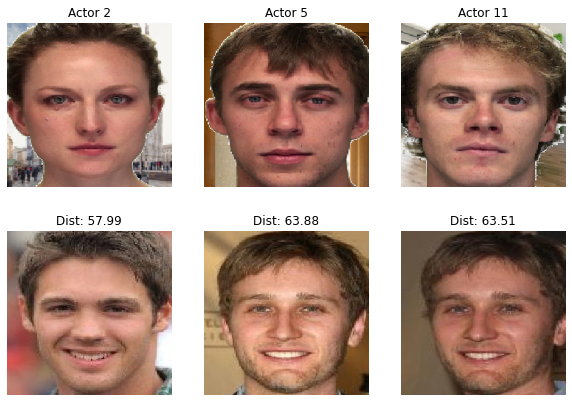

In [ ]:
im2 = kimage.load_img('/content/Actor_faces/01.png', target_size = (224, 224))
im5 = kimage.load_img('/content/Actor_faces/04.png', target_size = (224, 224))
im11 = kimage.load_img('/content/Actor_faces/10.png', target_size = (224, 224))
im2_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[1][0]).zfill(6) + '.jpg', target_size = (224, 224))
im5_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[4][0]).zfill(6) + '.jpg', target_size = (224, 224))
im11_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[10][0]).zfill(6) + '.jpg', target_size = (224, 224))

fig = plt.figure(figsize = (10, 7))

fig.add_subplot(2, 3, 1)
plt.imshow(im2)
plt.axis('off')
plt.title("Actor 2")
fig.add_subplot(2, 3, 2)
plt.imshow(im5)
plt.axis('off')
plt.title("Actor 5")
fig.add_subplot(2, 3, 3)
plt.imshow(im11)
plt.axis('off')
plt.title("Actor 11")

fig.add_subplot(2, 3, 4)
plt.imshow(im2_celeb)
plt.axis('off')
plt.title("Dist: 57.99")
fig.add_subplot(2, 3, 5)
plt.imshow(im5_celeb)
plt.axis('off')
plt.title("Dist: 63.88")
fig.add_subplot(2, 3, 6)
plt.imshow(im11_celeb)
plt.axis('off')
plt.title("Dist: 63.51")

# ResNet50V2

Now we use a ResNet50V2 as feature extractor. This network has many more parameters than MobileNetV2 and each image will be converted into a vector composed by 2048 features.

In [ ]:
resnet = keras.applications.ResNet50V2(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False, pooling = 'max')

94668760/94668760 [==============================] - 1s 0us/step


## Feature extraction

In order to optimize operations, we use list comprehension and a function to create the features. This saves us computation time by avoiding the append method.

For each image:
1.   Read image through Keras.
2.   Convert into numpy array.
3.   Apply preprocessing function.
4.   Return features.

The fill parameter is used in order to pad the index with the related name of the path (i.e. for celebrities index 91 becomes the path relative to 000091.jpg, for actors index 8 becomes the path relative to 08.png).

The path parameter is used in order to distinguish between query images and celeb images.

In [ ]:
def features_func(i, fill, path):
  # Load image
  im = kimage.load_img(path[:-4] + str(i).zfill(fill) + path[-4:], target_size = (224, 224))
  # Convert into numpy array
  x = kimage.img_to_array(im)
  # Preprocessing according to ResNet50V2
  x = keras.applications.resnet.preprocess_input(x)
  # Expand dimensions
  x = np.expand_dims(x, axis = 0)
  # Extract features
  feat = resnet.predict(x, verbose = False)
  # Return features
  return feat.flatten()

We create a list for celebrities, where each value represents the feature vector the related image.

In [ ]:
dir_list = os.listdir('/content/celeb/img_align_celeba/img_align_celeba/')
dir_list.sort()

features_celeb = [features_func(i, 6, path = '/content/celeb/img_align_celeba/img_align_celeba/.jpg') for i in range(len(dir_list))]

In [ ]:
features_celeb = np.array(features_celeb)
features_celeb.shape

(197389, 2048)

## KDTree

Building the search tree by means of KDTree from scikit-learn. 

In [ ]:
tree = KDTree(features_celeb)

Let's save the tree.

In [ ]:
joblib.dump(tree, '/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/res_tree.joblib')

At this point, we could restart the runtime in order to avoid RAM issues due to the features and the tree previously computed.

## Query

We query the tree that we previously saved. Specifically, we take the first 2 nearest-neighbors for each actor.

In [ ]:
tree = joblib.load('/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/res_tree.joblib')

In [ ]:
dir_list = os.listdir('/content/Actor_faces/')
dir_list.sort()

features_actors = [features_func(i, 2, path = '/content/Actor_faces/.png') for i in range(len(dir_list))]

In [ ]:
features_actors = np.array(features_actors)
features_actors.shape

(24, 2048)

In [ ]:
dist, ind = tree.query(features_actors, k = 2)

## Evaluation

In order to evaluate our results in a quantitative way, we compare some features from actors and celebrities, which have been stored separately in a csv. These features are in a binary format (e.g. Male = 1 or -1, Brown_Hair = 1 or -1). If we take, as accuracy measure, the ratio between the common features and the toal number of features, we may provide an empirical (but quantitative) way to measure the quality of retrieval.

In [ ]:
df_actors = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_actors.csv')
df_celeba = pd.read_csv('/content/gdrive/MyDrive/Digital Signal/Dataset/list_attr_celeba.csv')

In [ ]:
print('List of binary features:\n')
# We don't consider the first column because is the id of the image
print(list(df_actors.columns[1:]))

List of binary features:

['Arched_Eyebrows', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


Now we create, for both the images retrieved by KDTree as a match for each query, a list containing the values for accuracy and distance for each actor. Finally, we provide the final "accuracy score" by averaging the single accuracies on the actors.

In [ ]:
# Initializing lists
acc_list_1 = []
acc_list_2 = []
best_acc_list = []
dist_list_1 = []
dist_list_2 = []

# We don't consider the first column because is the id of the image
cols = df_actors.columns[1:]

# Compute accuracy and distance for each actor
for i in range(0, len(df_actors)):
  print('Actor ' + str(i + 1) + ':')
  count_1 = 0
  count_2 = 0
  # Save distances between actor and celebrity for both images
  dist_1 = round(dist[i][0], 2)
  dist_2 = round(dist[i][1], 2)
  dist_list_1.append(dist_1)
  dist_list_2.append(dist_2)
  # Save indices related to the actor for both images
  ind_1 = ind[i][0]
  ind_2 = ind[i][1]
  # Now we compute the matches between the binary atributes
  for j in cols:
    # Compute matches for the first image
    if(df_actors[j][i] == df_celeba[j][ind_1]):
      count_1+=1
    # Compute matches for the second image
    if(df_actors[j][i] == df_celeba[j][ind_2]):
      count_2+=1
  
  # Compute accuracy for the first image
  acc_1 = round((count_1/len(cols))*100, 2)
  acc_list_1.append(acc_1)
  print('Accuracy for first image: ' + str(acc_1) + '%')
  print('Distance for first image: ' + str(dist_1))

  # Compute accuracy for the second image
  acc_2 = round((count_2/len(cols))*100, 2)
  acc_list_2.append(acc_2)
  print('Accuracy for second image: ' + str(acc_2) + '%')
  print('Distance for second image: ' + str(dist_2) + '\n')

  # Saving best result
  best_acc_list.append(max(acc_1, acc_2))

print('Mean accuracy for first image: ' + str(round(np.mean(acc_list_1), 2)))
print('Mean accuracy for second image: ' + str(round(np.mean(acc_list_2), 2)))
print('Mean accuracy for top-2 images: ' + str(round(np.mean(best_acc_list), 2)))
print('Mean distance for first image: ' + str(round(np.mean(dist_list_1), 2)))
print('Mean distance for second image: ' + str(round(np.mean(dist_list_2), 2)))

Actor 1:
Accuracy for first image: 72.97%
Distance for first image: 7207.41
Accuracy for second image: 89.19%
Distance for second image: 7260.21

Actor 2:
Accuracy for first image: 56.76%
Distance for first image: 6759.49
Accuracy for second image: 83.78%
Distance for second image: 7113.29

Actor 3:
Accuracy for first image: 81.08%
Distance for first image: 7299.05
Accuracy for second image: 75.68%
Distance for second image: 7352.09

Actor 4:
Accuracy for first image: 75.68%
Distance for first image: 9343.87
Accuracy for second image: 78.38%
Distance for second image: 9368.39

Actor 5:
Accuracy for first image: 78.38%
Distance for first image: 7553.38
Accuracy for second image: 64.86%
Distance for second image: 7706.84

Actor 6:
Accuracy for first image: 75.68%
Distance for first image: 7026.48
Accuracy for second image: 70.27%
Distance for second image: 7124.92

Actor 7:
Accuracy for first image: 81.08%
Distance for first image: 8262.86
Accuracy for second image: 62.16%
Distance for s

* The total "empirical accuracy" for the first image is equal to 73.76% (-3.83% with respect to MobileNetV2).
* The total "empirical accuracy" for the top-2 images is equal to 78.72% (-2.36% with respect to MobileNetV2).

We may display the top-3 results in terms of accuracy from Actor1 (89.19%), Actor21 (89.19%) and Actor24 (86.49%).

Text(0.5, 1.0, 'Acc: 91.89%')

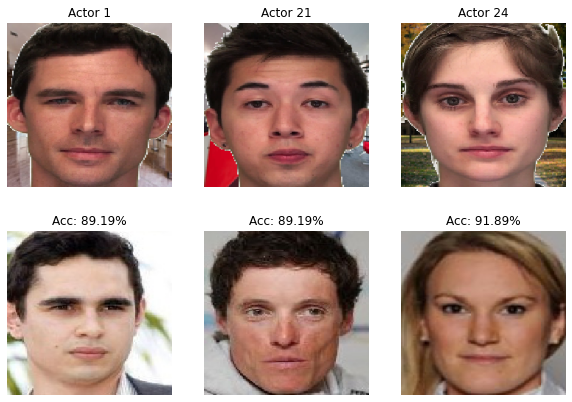

In [64]:
im1 = kimage.load_img('/content/Actor_faces/00.png', target_size = (224, 224))
im21 = kimage.load_img('/content/Actor_faces/20.png', target_size = (224, 224))
im24 = kimage.load_img('/content/Actor_faces/23.png', target_size = (224, 224))

im1_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[0][1]).zfill(6) + '.jpg', target_size = (224, 224))
im21_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[20][0]).zfill(6) + '.jpg', target_size = (224, 224))
im24_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[23][0]).zfill(6) + '.jpg', target_size = (224, 224))

fig = plt.figure(figsize = (10, 7))

fig.add_subplot(2, 3, 1)
plt.imshow(im1)
plt.axis('off')
plt.title("Actor 1")
fig.add_subplot(2, 3, 2)
plt.imshow(im21)
plt.axis('off')
plt.title("Actor 21")
fig.add_subplot(2, 3, 3)
plt.imshow(im24)
plt.axis('off')
plt.title("Actor 24")

fig.add_subplot(2, 3, 4)
plt.imshow(im1_celeb)
plt.axis('off')
plt.title("Acc: 89.19%")
fig.add_subplot(2, 3, 5)
plt.imshow(im21_celeb)
plt.axis('off')
plt.title("Acc: 89.19%")
fig.add_subplot(2, 3, 6)
plt.imshow(im24_celeb)
plt.axis('off')
plt.title("Acc: 86.49%")

We may display the top-3 results in terms of distance from Actor11 (6120.26), Actor13 (6271.1) and Actor19 (6013.86).

Text(0.5, 1.0, 'Dist: 6013.86')

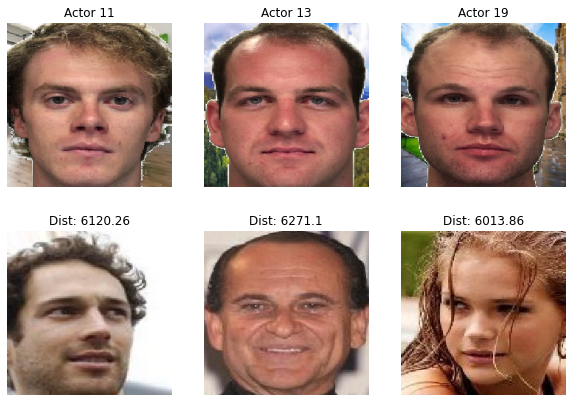

In [ ]:
im11 = kimage.load_img('/content/Actor_faces/10.png', target_size = (224, 224))
im13 = kimage.load_img('/content/Actor_faces/12.png', target_size = (224, 224))
im19 = kimage.load_img('/content/Actor_faces/18.png', target_size = (224, 224))

im11_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[10][0]).zfill(6) + '.jpg', target_size = (224, 224))
im13_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[12][1]).zfill(6) + '.jpg', target_size = (224, 224))
im19_celeb = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind[18][0]).zfill(6) + '.jpg', target_size = (224, 224))

fig = plt.figure(figsize = (10, 7))

fig.add_subplot(2, 3, 1)
plt.imshow(im11)
plt.axis('off')
plt.title("Actor 11")
fig.add_subplot(2, 3, 2)
plt.imshow(im13)
plt.axis('off')
plt.title("Actor 13")
fig.add_subplot(2, 3, 3)
plt.imshow(im19)
plt.axis('off')
plt.title("Actor 19")

fig.add_subplot(2, 3, 4)
plt.imshow(im11_celeb)
plt.axis('off')
plt.title("Dist: 6120.26")
fig.add_subplot(2, 3, 5)
plt.imshow(im13_celeb)
plt.axis('off')
plt.title("Dist: 6271.1")
fig.add_subplot(2, 3, 6)
plt.imshow(im19_celeb)
plt.axis('off')
plt.title("Dist: 6013.86")

# Further tests

Now we can try to use the query the tree with some personal images.

In [ ]:
mobilenet = keras.applications.MobileNetV2(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False, pooling = 'max')

In [ ]:
resnet = keras.applications.ResNet50V2(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False, pooling = 'max')

In [ ]:
remo = kimage.load_img('/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Remo.jpg', target_size = (224,224))
nicco = kimage.load_img('/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Nicco.jpg', target_size = (224,224))
gian = kimage.load_img('/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Gian.jpg', target_size = (224,224))

Text(0.5, 1.0, 'Gianluca')

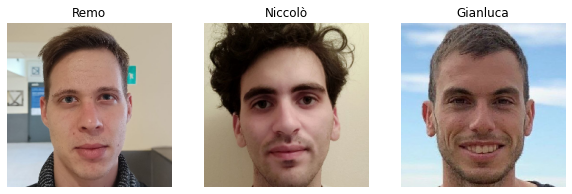

In [ ]:
fig = plt.figure(figsize = (10, 7))

fig.add_subplot(1, 3, 1)
plt.imshow(remo)
plt.axis('off')
plt.title("Remo")

fig.add_subplot(1, 3, 2)
plt.imshow(nicco)
plt.axis('off')
plt.title("Niccolò")

fig.add_subplot(1, 3, 3)
plt.imshow(gian)
plt.axis('off')
plt.title("Gianluca")

In [ ]:
def features_func_mob(path):
  # Load image
  im = kimage.load_img(path, target_size = (224, 224))
  # Convert into numpy array
  x = kimage.img_to_array(im)
  # Preprocessing according to MobileNetV2
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  # Expand dimensions
  x = np.expand_dims(x, axis = 0)
  # Extract features
  feat = mobilenet.predict(x, verbose = False)
  # Return features
  return feat.flatten()

def features_func_res(path):
  # Load image
  im = kimage.load_img(path, target_size = (224, 224))
  # Convert into numpy array
  x = kimage.img_to_array(im)
  # Preprocessing according to ResNet50V2
  x = keras.applications.resnet.preprocess_input(x)
  # Expand dimensions
  x = np.expand_dims(x, axis = 0)
  # Extract features
  feat = resnet.predict(x, verbose = False)
  # Return features
  return feat.flatten()

In [ ]:
features_pers_mob = []
features_pers_res = []

features_pers_mob.extend([features_func_mob(path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Remo.jpg'),
                          features_func_mob(path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Nicco.jpg'),
                          features_func_mob(path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Gian.jpg')
                          ])

features_pers_res.extend([features_func_res(path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Remo.jpg'),
                          features_func_res(path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Nicco.jpg'),
                          features_func_res(path = '/content/gdrive/MyDrive/Digital Signal/Dataset/Personalized_faces/Gian.jpg')
                          ])

In [ ]:
features_pers_mob = np.array(features_pers_mob)
features_pers_res = np.array(features_pers_res)
print(features_pers_mob.shape)
print(features_pers_res.shape)

(3, 1280)
(3, 2048)


Now we can query both the trees: the one built with MobileNetV2 approach and the other built with ResNet50V2 approach.

In [ ]:
tree_m = joblib.load('/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/mob_tree.joblib')

In [ ]:
tree_r = joblib.load('/content/gdrive/MyDrive/Digital Signal/Models/Image Retrieval/res_tree.joblib')

In [ ]:
dist_m, ind_m = tree_m.query(features_pers_mob, k = 1)
dist_r, ind_r = tree_r.query(features_pers_res, k = 1)

In [ ]:
im_remo_mob = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind_m[0][0]).zfill(6) + '.jpg', target_size = (224, 224))
im_nicco_mob = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind_m[1][0]).zfill(6) + '.jpg', target_size = (224, 224))
im_gian_mob = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind_m[2][0]).zfill(6) + '.jpg', target_size = (224, 224))

im_remo_res = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind_r[0][0]).zfill(6) + '.jpg', target_size = (224, 224))
im_nicco_res = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind_r[1][0]).zfill(6) + '.jpg', target_size = (224, 224))
im_gian_res = kimage.load_img('/content/celeb/img_align_celeba/img_align_celeba/' + str(ind_r[2][0]).zfill(6) + '.jpg', target_size = (224, 224))

Let's display the images according to the subjects.

Text(0.5, 1.0, 'ResNet50V2')

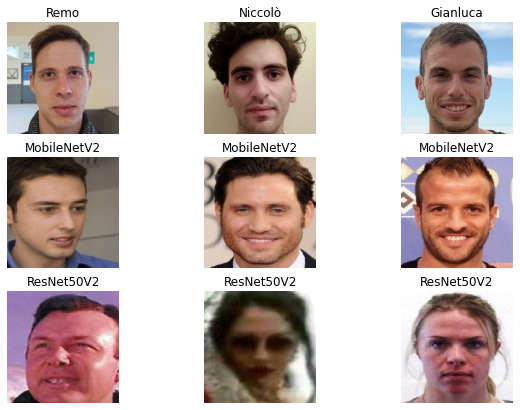

In [ ]:
fig = plt.figure(figsize = (10, 7))

fig.add_subplot(3, 3, 1)
plt.imshow(remo)
plt.axis('off')
plt.title("Remo")

fig.add_subplot(3, 3, 2)
plt.imshow(nicco)
plt.axis('off')
plt.title("Niccolò")

fig.add_subplot(3, 3, 3)
plt.imshow(gian)
plt.axis('off')
plt.title("Gianluca")

fig.add_subplot(3, 3, 4)
plt.imshow(im_remo_mob)
plt.axis('off')
plt.title("MobileNetV2")

fig.add_subplot(3, 3, 5)
plt.imshow(im_nicco_mob)
plt.axis('off')
plt.title("MobileNetV2")

fig.add_subplot(3, 3, 6)
plt.imshow(im_gian_mob)
plt.axis('off')
plt.title("MobileNetV2")

fig.add_subplot(3, 3, 7)
plt.imshow(im_remo_res)
plt.axis('off')
plt.title("ResNet50V2")

fig.add_subplot(3, 3, 8)
plt.imshow(im_nicco_res)
plt.axis('off')
plt.title("ResNet50V2")

fig.add_subplot(3, 3, 9)
plt.imshow(im_gian_res)
plt.axis('off')
plt.title("ResNet50V2")